In [78]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
plt.style.use('default')
import pandas as pd
from sklearn.decomposition import NMF, PCA
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Dense, Attention, TimeDistributed, Embedding, GlobalAveragePooling1D, Flatten, MultiHeadAttention, SimpleRNN, GRU, Dropout, LSTM, Bidirectional, Lambda
import tensorflow_hub as hub
import tensorflow as tf
import tensorflow_text
from tensorflow.keras.backend import sum
from tensorflow.keras.utils import plot_model
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report


# Exercício 1
*Objetivo: gerar um classificador com modelo de atenção BLSTM*

A rede neural abaixo usa um ramo de atenção com uma LSTM bidirecional.

1. O que significa "atenção"?
1. Como atenção pode melhorar nosso resultado de predição?
1. Como atenção pode tornar nossa rede neural mais interpretável?


In [52]:
df = pd.read_csv('./datasets/IMDB Dataset.csv')
reviews = list(df['review'])

labels = np.array([list(df['sentiment'])]).T
ohe = OneHotEncoder()
y = ohe.fit_transform(labels).toarray()

In [53]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(reviews)
sequences = tokenizer.texts_to_sequences(reviews)

In [54]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
padded = pad_sequences(sequences,maxlen=200)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(padded, y, test_size=0.2)

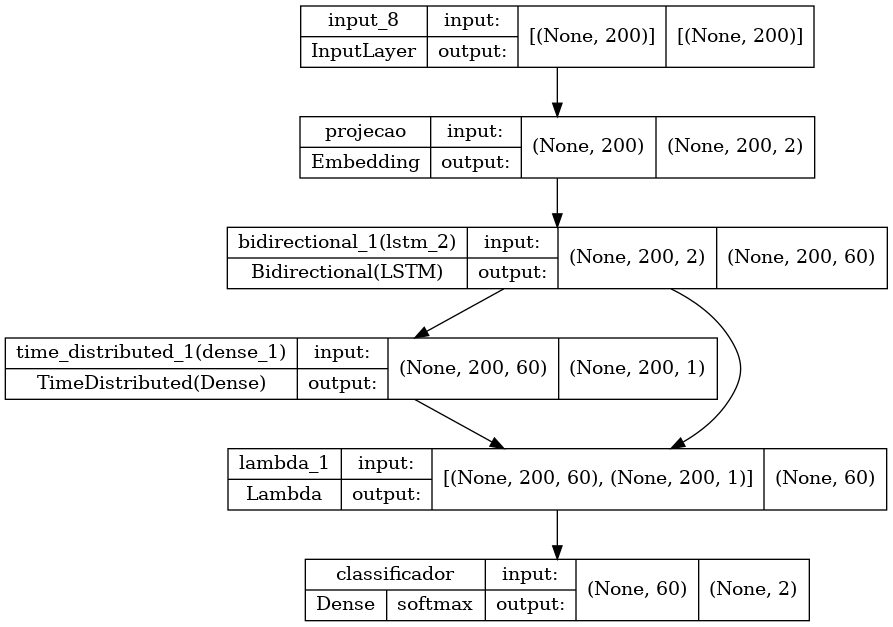

In [56]:
def aplicar_atencao(par):
  estados, atencao = par[0], par[1]
  atencao_aplicada = estados * atencao
  contexto = sum(atencao_aplicada, axis=1)
  return contexto

def rede_neural_com_atencao_bidirecional(input_dims, n_dims_out):
  input_layer = Input(shape=(input_dims,))
  x = input_layer
  x = Embedding(1000, 2, name='projecao')(x)
  x_forward = LSTM(30, return_sequences=True)
  x_backward = LSTM(30, return_sequences=True, go_backwards=True)
  x = Bidirectional(x_forward, backward_layer=x_backward)(x)

  atencao = TimeDistributed(Dense(1, activation='sigmoid'))(x)
  contexto = Lambda(aplicar_atencao)( [x, atencao] )

  y = Dense(2, activation='softmax', name='classificador')(contexto)
  return Model(input_layer, y), Model(input_layer, atencao)

rede_neural, atencao = rede_neural_com_atencao_bidirecional(200, 2)
rede_neural.compile(optimizer='adam', loss='mse')
plot_model(rede_neural, show_shapes=True, show_layer_activations=True, expand_nested=True)

In [57]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
history = rede_neural.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=es)

Epoch 1/50
1000/1000 [==============================] - 20s 18ms/step - loss: 0.1367 - val_loss: 0.1046
Epoch 2/50
1000/1000 [==============================] - 17s 17ms/step - loss: 0.1027 - val_loss: 0.1010
Epoch 3/50
1000/1000 [==============================] - 17s 17ms/step - loss: 0.0987 - val_loss: 0.1015
Epoch 4/50
1000/1000 [==============================] - 17s 17ms/step - loss: 0.0970 - val_loss: 0.1026
Epoch 5/50
1000/1000 [==============================] - 17s 17ms/step - loss: 0.0954 - val_loss: 0.1017
Epoch 6/50
1000/1000 [==============================] - 17s 17ms/step - loss: 0.0938 - val_loss: 0.1027
Epoch 7/50
1000/1000 [==============================] - 19s 19ms/step - loss: 0.0908 - val_loss: 0.0948
Epoch 8/50
1000/1000 [==============================] - 18s 18ms/step - loss: 0.0872 - val_loss: 0.0924
Epoch 9/50
1000/1000 [==============================] - 18s 18ms/step - loss: 0.0842 - val_loss: 0.0919
Epoch 10/50
1000/1000 [==============================] - 17s 17m

In [58]:
y_est = rede_neural.predict(X_test)
print(classification_report(ohe.inverse_transform(y_test), ohe.inverse_transform(y_est)))

              precision    recall  f1-score   support

    negative       0.88      0.87      0.87      5027
    positive       0.87      0.88      0.87      4973

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



In [59]:
at = atencao.predict(X_test)
#print(X_test[0])
#print(at[0])
words = tokenizer.sequences_to_texts(X_test)

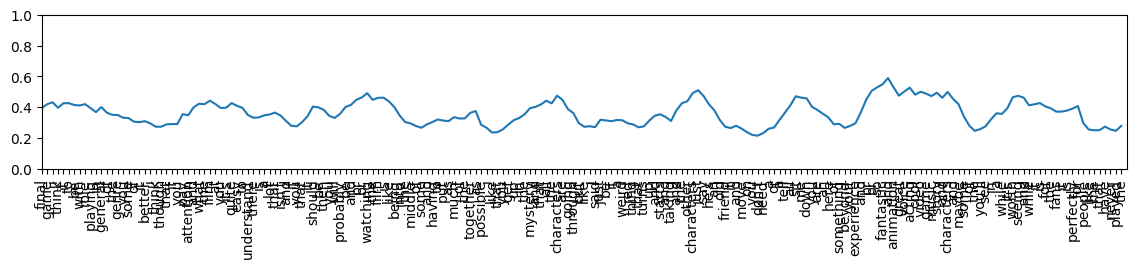

In [60]:
idx=88
plt.figure(figsize=(14,2))
n_words = len(words[idx].split())
at_ = at[idx,-n_words:]
plt.plot(at_)
plt.xticks(range(n_words), words[idx].split(), rotation=90)
plt.xlim([0,n_words])
plt.ylim([0,1])
plt.show()

# Exercício 2
*Objetivo: interpretar uma rede neural com modelo de auto-atenção*

O mecanismo de auto-atenção funciona diferente do mecanismo de atenção com um ramo externo.

1. Por que a camada de atenção tem duas entradas? O que elas significam?
1. Qual é a dimensão das saídas da camada de atenção? Como as saídas devem ser interpretadas?
1. Qual é a função da camada `GlobalAveragePooling1D`?
1. A camada `GlobalAveragePooling1D` poderia ser trocada por uma rede recorrente (LSTM, por exemplo)?
1. Como a atenção gerada por esta rede pode ser visualizada? Como essa informação se compara com aquela fornecida pela atenção via LSTM?
1. Como o tempo de treinamento desta rede se compara com o tempo de treino da LSTM?

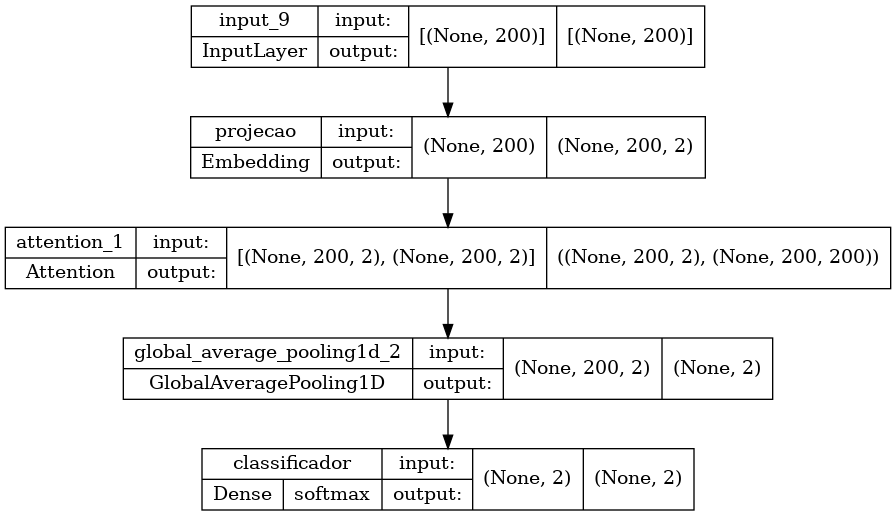

In [61]:
def rede_neural_com_auto_atencao(input_dims, n_dims_out):
  input_layer = Input(shape=(input_dims,))
  x = input_layer
  x = Embedding(1000, 2, name='projecao')(x)
  x, atencao = Attention()([x, x], return_attention_scores=True)
  x = GlobalAveragePooling1D()(x)
  y = Dense(2, activation='softmax', name='classificador')(x)
  return Model(input_layer, y), Model(input_layer, atencao)

rede_neural, atencao = rede_neural_com_auto_atencao(200, 2)
rede_neural.compile(optimizer='adam', loss='mse')
plot_model(rede_neural, show_shapes=True, show_layer_activations=True, expand_nested=True)

In [62]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
history = rede_neural.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=es)


Epoch 1/50
1000/1000 [==============================] - 3s 3ms/step - loss: 0.2318 - val_loss: 0.2026
Epoch 2/50
1000/1000 [==============================] - 3s 3ms/step - loss: 0.1673 - val_loss: 0.1375
Epoch 3/50
1000/1000 [==============================] - 3s 3ms/step - loss: 0.1249 - val_loss: 0.1152
Epoch 4/50
1000/1000 [==============================] - 3s 3ms/step - loss: 0.1108 - val_loss: 0.1068
Epoch 5/50
1000/1000 [==============================] - 3s 3ms/step - loss: 0.1042 - val_loss: 0.1027
Epoch 6/50
1000/1000 [==============================] - 3s 3ms/step - loss: 0.1005 - val_loss: 0.1006
Epoch 7/50
1000/1000 [==============================] - 3s 3ms/step - loss: 0.0980 - val_loss: 0.0996
Epoch 8/50
1000/1000 [==============================] - 3s 3ms/step - loss: 0.0963 - val_loss: 0.0990
Epoch 9/50
1000/1000 [==============================] - 3s 3ms/step - loss: 0.0951 - val_loss: 0.0984
Epoch 10/50
1000/1000 [==============================] - 3s 3ms/step - loss: 0.094

In [63]:
y_est = rede_neural.predict(X_test)
print(classification_report(ohe.inverse_transform(y_test), ohe.inverse_transform(y_est)))

              precision    recall  f1-score   support

    negative       0.87      0.85      0.86      5027
    positive       0.85      0.87      0.86      4973

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



(200, 200)


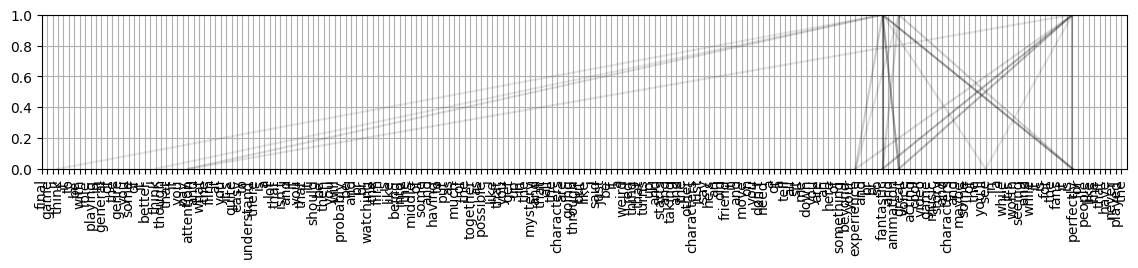

In [64]:
idx=88
at = atencao.predict(X_test[idx:idx+1,:])
words = tokenizer.sequences_to_texts(X_test[idx:idx+1,:])
print(at[0,:].shape)
plt.figure(figsize=(14,2))
n_words = len(words[0].split())
for i in range(n_words): # Para cada palavra
    for j in range(n_words): # Para cada palavra ^2
        #print(i, j, at[0,i,j])
        if at[0,i,j] > 0.1:
            plt.plot([i, j], [0, 1], c='k', alpha=at[0,i,j])
#plt.plot(at_)
plt.xticks(range(n_words), words[0].split(), rotation=90)
plt.grid()
plt.xlim([0,n_words])
plt.ylim([0,1])
plt.show()

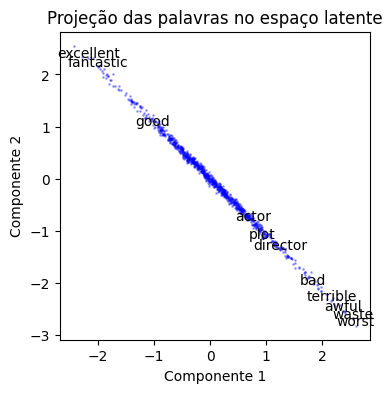

In [65]:
# Visualização: onde foi parar cada palavra?
v_ = rede_neural.get_layer('projecao').get_weights()[0]

#proj = PCA(n_components=2, perplexity=5)
#v = proj.fit_transform(v_)
v = v_

plt.figure(figsize=(4,4))
plt.scatter(v[:,0], v[:,1], s=1, alpha=0.3, c='b')
for s in ["director", "actor", "bad", "good", "excellent", "plot", "worst", "terrible", "waste", "awful", "fantastic"]:
    _n = tokenizer.texts_to_sequences([[s]])[0][0]
    plt.text(v[_n,0], v[_n,1], s, ha='center')
plt.title('Projeção das palavras no espaço latente')
plt.ylabel('Componente 2')
plt.xlabel('Componente 1')
#plt.xlim([-20,20])
#plt.ylim([-20,20])
plt.show()

# Exercício 3
*Objetivo: interpretar uma rede neural com multi-head attention*

A rede neural abaixo usa multi-head attention no lugar de uma camada de auto-atenção simples.

1. Quais são as dimensões das saídas da camada `MultiHeadAttention`? Como isso se compara com as dimensões da saída da camada de atenção simples?
1. Como o tempo de treinamento se compara com aquele relacionado à atenção simples?
1. As atenções relacionadas a cada um dos elementos da `MultiHeadAttention` são estritamente iguais? São iguais à atenção gerada pela LSTM? São iguais à atenção gerada pela atenção simples? O que cada uma delas representa?
1. 

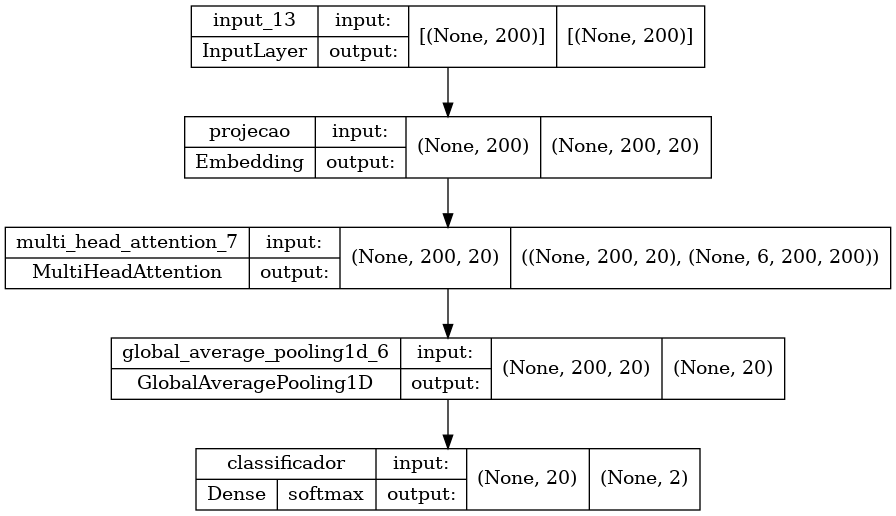

In [86]:
def rede_neural_com_multi_auto_atencao(input_dims, n_dims_out):
  input_layer = Input(shape=(input_dims,))
  x = input_layer
  x = Embedding(1000, 20, name='projecao')(x)
  x, atencao = MultiHeadAttention(num_heads=6, key_dim=20, value_dim=20)(query=x, value=x, key=x, return_attention_scores=True)
  x = GlobalAveragePooling1D()(x)
  y = Dense(2, activation='softmax', name='classificador')(x)
  return Model(input_layer, y), Model(input_layer, atencao)

rede_neural, atencao = rede_neural_com_multi_auto_atencao(200, 2)
rede_neural.compile(optimizer='adam', loss='mse')
plot_model(rede_neural, show_shapes=True, show_layer_activations=True, expand_nested=True)

In [87]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
history = rede_neural.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=es)


Epoch 1/50
1000/1000 [==============================] - 5s 5ms/step - loss: 0.1285 - val_loss: 0.1045
Epoch 2/50
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0993 - val_loss: 0.0997
Epoch 3/50
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0966 - val_loss: 0.1021
Epoch 4/50
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0958 - val_loss: 0.0999
Epoch 5/50
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0953 - val_loss: 0.0998
Epoch 6/50
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0948 - val_loss: 0.0994
Epoch 7/50
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0941 - val_loss: 0.1006
Epoch 8/50
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0933 - val_loss: 0.1025
Epoch 9/50
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0929 - val_loss: 0.1024
Epoch 10/50
1000/1000 [==============================] - 4s 4ms/step - loss: 0.092

In [89]:
y_est = rede_neural.predict(X_test)
print(classification_report(ohe.inverse_transform(y_test), ohe.inverse_transform(y_est)))

              precision    recall  f1-score   support

    negative       0.87      0.85      0.86      5027
    positive       0.85      0.87      0.86      4973

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



(1, 6, 200, 200)


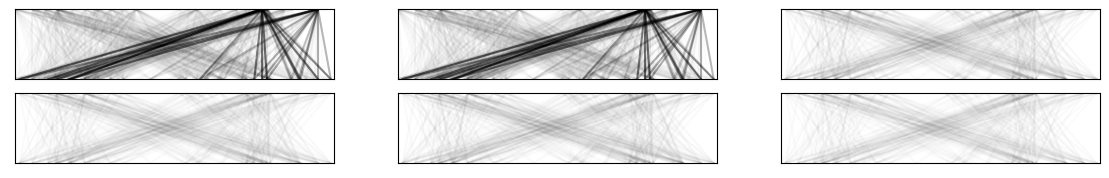

In [96]:
idx=88
at = atencao.predict(X_test[idx:idx+1,:])
words = tokenizer.sequences_to_texts(X_test[idx:idx+1,:])
print(at.shape)
plt.figure(figsize=(14,2))
n_words = len(words[0].split())
for i in range(n_words): # Para cada palavra
    for j in range(n_words): # Para cada palavra ^2
        #print(i, j, at[0,i,j])
        for k in range(6):
            plt.subplot(2, 3, k+1)
            if at[0,k,i,j] > 0.01:
                plt.plot([i, j], [0, 1], c='k', alpha=at[0,k,i,j])
#plt.plot(at_)

for k in range(6):
    plt.subplot(2, 3, k+1)
    plt.xticks([])
    plt.yticks([])
    plt.xlim([0,n_words])
    plt.ylim([0,1])

plt.show()

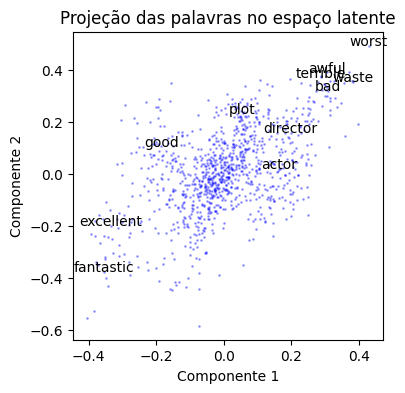

In [91]:
# Visualização: onde foi parar cada palavra?
v_ = rede_neural.get_layer('projecao').get_weights()[0]

proj = PCA(n_components=2)
v = proj.fit_transform(v_)
v = v_

plt.figure(figsize=(4,4))
plt.scatter(v[:,0], v[:,1], s=1, alpha=0.3, c='b')
for s in ["director", "actor", "bad", "good", "excellent", "plot", "worst", "terrible", "waste", "awful", "fantastic"]:
    _n = tokenizer.texts_to_sequences([[s]])[0][0]
    plt.text(v[_n,0], v[_n,1], s, ha='center')
plt.title('Projeção das palavras no espaço latente')
plt.ylabel('Componente 2')
plt.xlabel('Componente 1')
#plt.xlim([-20,20])
#plt.ylim([-20,20])
plt.show()

# Exercício 4
*Objetivo: entender o experimento Cloze*

1. Complete as frases abaixo:
* Hoje foi um dia lindo por que fez _______
* Precisamos reduzir, reusar e ______
* Olá amigo! Já faz muito ____ que não nos falamos!
* Na aula de NLP, aprendi a _______

1. Por que você conseguiu completar as frases? Em que situações elas são difíceis de completar?


# Exercício 5
*Objetivo: baixar o modelo BERT pré-treinado e usá-lo*

O modelo BERT é um transformer pré-treinado com mascaramento (experimento *cloze*). É importante baixá-lo porque ele é muito grande e seria impraticável treiná-lo na sala!

O modelo BERT pré-treinado se comporta como uma camada no Keras.

Que tipo de camadas (dentre as que vimos acima) são substituídas pelo BERT?

In [98]:
text_input = Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    trainable=False)
encoder_inputs = preprocessor(text_input)
encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2",
    trainable=False)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]      # [batch_size, 128].
sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 128].

## Mapear frases para embeddings

In [102]:
embedding_model = Model(text_input, pooled_output)
sentences = tf.constant(["Fruit flies like fruits"])
print(embedding_model(sentences)[0][0:30])


tf.Tensor(
[-0.99992317 -0.09821874 -0.9810755   0.9961578  -0.9414414   0.8527529
  0.5728734  -0.97292566  0.25628147  0.11873839 -0.9481955  -0.13146825
  0.01624526  0.9993021  -0.94982207  0.29250073 -0.564312    0.16582233
 -0.9731316  -0.5952562   0.8025156  -0.16474368  0.91805536  0.36802024
 -0.99538416 -0.08383191 -0.9899272   0.97449845  0.8950425  -0.03835467], shape=(30,), dtype=float32)


## Um modelo incorporando BERT

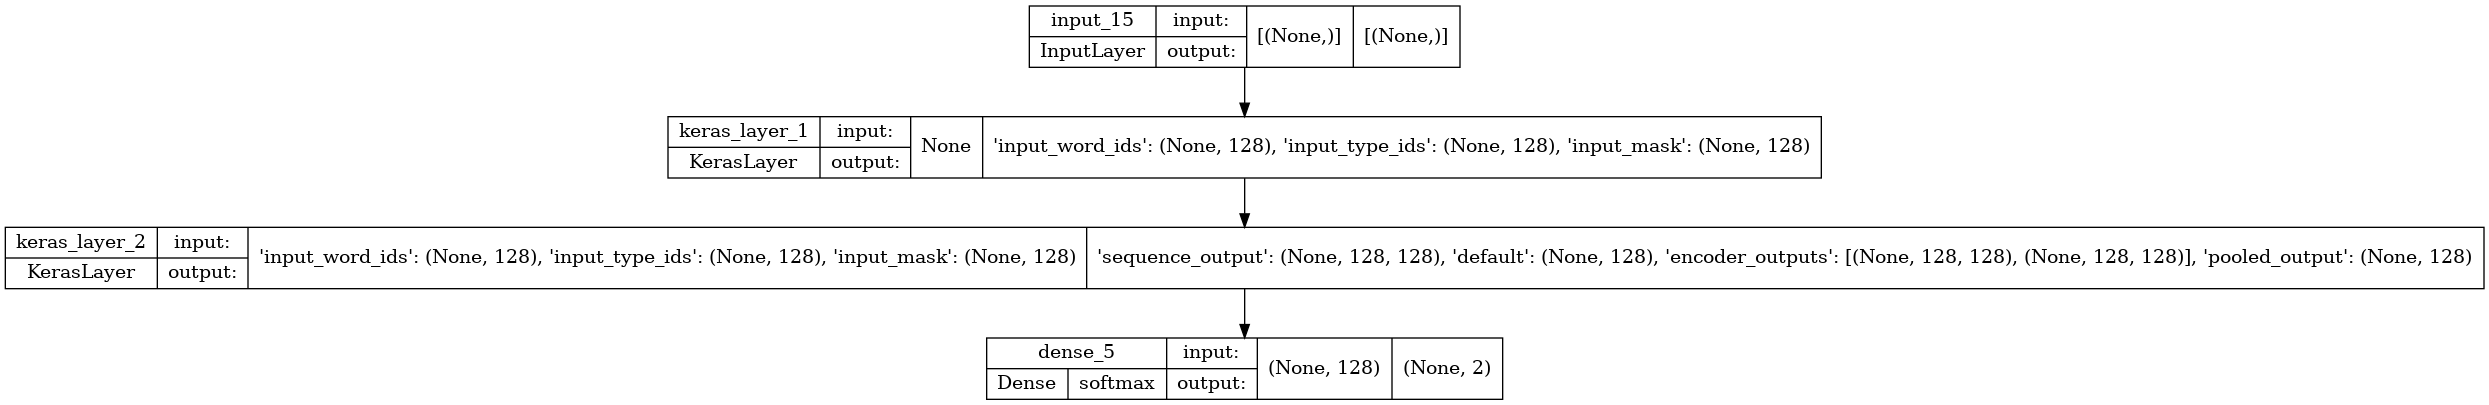

In [104]:
saida = Dense(2, activation='softmax')(pooled_output)
rede_neural = Model(text_input, saida)
rede_neural.compile(optimizer='adam', loss='categorical_crossentropy')
plot_model(rede_neural, show_shapes=True, show_layer_activations=True)

In [105]:
df = pd.read_csv('./datasets/IMDB Dataset.csv')
reviews = list(df['review'])
labels = np.array([list(df['sentiment'])]).T
ohe = OneHotEncoder()
y_ohe = ohe.fit_transform(labels).toarray()

X_train, X_test, y_train, y_test = train_test_split(reviews, y_ohe, test_size=0.2)

In [106]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3, restore_best_weights=True)
history = rede_neural.fit(tf.convert_to_tensor(X_train), y_train, epochs=500, validation_split=0.2, callbacks=es)

Epoch 1/500
1000/1000 [==============================] - 79s 77ms/step - loss: 0.6548 - val_loss: 0.6347
Epoch 2/500
1000/1000 [==============================] - 77s 77ms/step - loss: 0.6274 - val_loss: 0.6249
Epoch 3/500
1000/1000 [==============================] - 78s 78ms/step - loss: 0.6188 - val_loss: 0.6188
Epoch 4/500
1000/1000 [==============================] - 76s 76ms/step - loss: 0.6142 - val_loss: 0.6204
Epoch 5/500
1000/1000 [==============================] - 77s 77ms/step - loss: 0.6112 - val_loss: 0.6129
Epoch 6/500
1000/1000 [==============================] - 76s 76ms/step - loss: 0.6089 - val_loss: 0.6178
Epoch 7/500
1000/1000 [==============================] - 76s 76ms/step - loss: 0.6085 - val_loss: 0.6101
Epoch 8/500
1000/1000 [==============================] - 76s 76ms/step - loss: 0.6067 - val_loss: 0.6111
Epoch 9/500
1000/1000 [==============================] - 76s 76ms/step - loss: 0.6054 - val_loss: 0.6095
Epoch 10/500
1000/1000 [==============================]

KeyboardInterrupt: 

In [ ]:
y_est = rede_neural.predict(tf.convert_to_tensor(X_test))
print(classification_report(ohe.inverse_transform(y_test), ohe.inverse_transform(y_est)))

# Exercício 6
*Objetivo: usar agregação de palavras ao longo do tempo e o modelo BERT*

BERT também pode nos fornecer uma transformação para cada palavra da sequência, como no código abaixo.

1. No código abaixo, que camada faz a função de agregar as sequências em um único vetor para ser compilado?
1. Qual camada da rede abaixo poderia ser substituída por uma *multi-head self-attention*?
1. Incorpore o modelo de *multi-head self attention* para modificar a rede abaixo.
1. Como essa modificação afeta os resultados?

In [ ]:
agregador = LSTM(256)(sequence_output)
saida = Dense(2, activation='softmax')(agregador)
rede_neural = Model(text_input, saida)
rede_neural.compile(optimizer='adam', loss='categorical_crossentropy')
plot_model(rede_neural, show_shapes=True, show_layer_activations=True)

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3, restore_best_weights=True)
history = rede_neural.fit(tf.convert_to_tensor(X_train), y_train, epochs=500, validation_split=0.2, callbacks=es)

In [ ]:
y_est = rede_neural.predict(tf.convert_to_tensor(X_test))
print(classification_report(ohe.inverse_transform(y_test), ohe.inverse_transform(y_est)))